In [1]:
import os
import ee
import datetime
import time
import io
import requests
import urllib.request

import geopandas as gp
import numpy as np
import pandas as pd
import rsfuncs as rs
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
from tqdm.notebook import tqdm

ee.Initialize()

%load_ext autoreload
%autoreload 2

In [2]:
# Select area
shp = gp.read_file("../shape/argus_grace.shp")
area = rs.gdf_to_ee_poly(shp)

# Load data
data = rs.load_data()

In [3]:
# Set GRACE study period 
strstart = '2002-04-01'
strend = '2017-03-31'

startgrace = datetime.datetime.strptime(strstart, "%Y-%m-%d")
endgrace = datetime.datetime.strptime(strend, "%Y-%m-%d")
# Get grace products
cri = rs.get_grace(data['cri'], startgrace, endgrace, area)
mas = rs.get_grace(data['mas'], startgrace, endgrace, area)
gfz = rs.get_grace(data['gfz'], startgrace, endgrace, area)
csr = rs.get_grace(data['csr'], startgrace, endgrace, area)
jpl = rs.get_grace(data['jpl'], startgrace, endgrace, area)

processing:
NASA/GRACE/MASS_GRIDS/MASCON_CRI/20020331_20020429



processing:
NASA/GRACE/MASS_GRIDS/MASCON/20020331_20020429



processing:
NASA/GRACE/MASS_GRIDS/LAND/20020401_20020430



processing:
NASA/GRACE/MASS_GRIDS/LAND/20020401_20020430



processing:
NASA/GRACE/MASS_GRIDS/LAND/20020401_20020430


In [4]:
# Compile grace data 
df = pd.concat([cri,gfz,jpl,mas,csr], axis = 1)
df.columns = ['cri','gfz','jpl','mas','csr']
df['grace_mean'] = np.nanmean( [df.cri,df.gfz,df.jpl,df.mas,df.csr] , axis = 0)
df['grace_median'] = np.nanmedian( [df.cri,df.gfz,df.jpl,df.mas,df.csr] , axis = 0)
df.index = pd.date_range(startgrace,endgrace, freq="M")
df.index = df.index + MonthEnd(0)


<ipython-input-4-b6dddf6c49ac>:4: RuntimeWarning: Mean of empty slice
  df['grace_mean'] = np.nanmean( [df.cri,df.gfz,df.jpl,df.mas,df.csr] , axis = 0)
/anaconda3/envs/sci/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [5]:
# Now the Hydrology data 

In [6]:
# Add an extra month beforehand, since we are differencing from the starting point, (e.g. dS/dt) 
strstart = '2002-03-01'
strend = '2017-03-31'

startdate = datetime.datetime.strptime(strstart, "%Y-%m-%d")
enddate = datetime.datetime.strptime(strend, "%Y-%m-%d")

# Soil moisture
tc_sm = rs.calc_monthly_mean(data['tc_sm'], startdate, enddate, area)

gldas_gsm1 = rs.calc_monthly_mean(data['gsm1'], startdate, enddate, area)
gldas_gsm2 = rs.calc_monthly_mean(data['gsm2'], startdate, enddate, area)
gldas_gsm3 = rs.calc_monthly_mean(data['gsm3'], startdate, enddate, area)
gldas_gsm4 = rs.calc_monthly_mean(data['gsm4'], startdate, enddate, area)

# SWE
fldas_swe = rs.calc_monthly_mean(data['fldas_swe'], startdate,enddate, area)
gldas_swe = rs.calc_monthly_mean(data['gldas_swe'], startdate,enddate, area)
tc_swe = rs.calc_monthly_mean(data['tc_swe'], startdate,enddate, area)
dmet_swe = rs.calc_monthly_mean(data['dmet_swe'], startdate,enddate, area)

processing:
IDAHO_EPSCOR/TERRACLIMATE/195801



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
NASA/FLDAS/NOAH01/C/GL/M/V001/198201



processing:
NASA/GLDAS/V021/NOAH/G025/T3H/A20000102_0000



processing:
IDAHO_EPSCOR/TERRACLIMATE/195801


processing:
NASA/ORNL/DAYMET_V3/19800101


In [8]:
shpfile = "../shape/argus_grace.shp"

# Get the Reservoir data in the grace domain 
print("**** Begin Fetching CDEC Reservoir Storage Data for {} ****".format(shpfile))

# Read the shapefile 
gdf = gp.read_file(shpfile)

# Spatial join cdec reservoirs to supplied gdf 
reservoirs = gp.read_file("../shape/cdec_reservoirs.shp")
within_gdf = gp.sjoin(reservoirs, gdf, how='inner', op='within')

# Download Storage (SensorNums = 15) data by query str:
start = datetime.datetime(1997, 1, 1)
end = datetime.datetime(2020, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

data = {}

for i in tqdm(within_gdf.ID):
    print("processing " + i )
    url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=1997-01-01&End=2020-01-01".format(i)
    urlData = requests.get(url).content
    resdf = pd.read_csv(io.StringIO(urlData.decode('utf-8')))

    if resdf.empty:
        pass
    else:
        data[i] = resdf

storage = []
for k,v in data.items():
    dat = pd.to_numeric(data[k].VALUE, errors = "coerce")
    if not len(dat) < len(dt_idx):
        storage.append(pd.to_numeric(data[k].VALUE, errors = "coerce"))

storage_sum = np.nansum(np.column_stack(storage), axis = 1) * 1.23348e-6 # acre ft to km^3
Sres = pd.DataFrame(zip(dt_idx,storage_sum), columns = ['date',"Sres"])
Sres.set_index('date', inplace = True)

print("Mean reservoir storage = {} km^3".format(np.mean(Sres)))

print("Reservoir Storage DONE ====================================== ")



**** Begin Fetching CDEC Reservoir Storage Data for ../shape/argus_grace.shp ****


processing ABY
processing ADI
processing ADN
processing AGP
processing APH
processing ALT
processing AMF
processing APS
processing APU
processing ANT
processing ANR
processing ATS
processing ATP
processing AVL
processing ASH
processing ASM
processing ATW
processing ABR
processing AUB
processing BDF
processing BFK
processing BAL
processing BNG
processing BHM
processing BBS
processing CFW
processing BRM
processing BV1
processing BMD
processing BRD
processing BHV
processing BEM
processing BNH
processing BER
processing BGC
processing BFT
processing BGM
processing BMS
processing BP1
processing BP2
processing BP3
processing BWH
processing BGH
processing BIS
processing BSP
processing BSH
processing BLB
processing BLS
processing BCB
processing BMN
processing BLD
processing BLC
processing BYM
processing BLU
processing BLK
processing BCA
processing BOC
processing BDE
processing BNP
processing BNM
processing BOW
processing BOL
processing BOM
processing BWN
processing BXC
processing BWR
processing

processing TMK
processing TMF
processing TNY
processing TRM
processing TMT
processing TAB
processing THD
processing TFR
processing TAE
processing THL
processing 3LK
processing 3RV
processing TCP
processing TNM
processing TGP
processing TCR
processing TRG
processing TRL
processing CLE
processing TNL
processing TRF
processing TKT
processing TKE
processing 6SI
processing TUL
processing STU
processing TUM
processing TLG
processing TLC
processing TND
processing USL
processing UNV
processing UBC
processing UCP
processing UKR
processing UTR
processing UWD
processing VNN
processing VNT
processing VGL
processing VRG
processing VSL
processing VLC
processing WBM
processing WR2
processing WRN
processing WSC
processing WVR
processing WBB
processing WPK
processing WFC
processing WPT
processing WWR
processing WHN
processing WHE
processing WHK
processing WHI
processing WLF
processing WLW
processing WSN
processing WSD
processing WLC
processing WDH
processing WDL
processing WRG
processing YSV
processing

In [9]:
# Compile hydro data 
gldas_sm = pd.DataFrame(pd.concat([gldas_gsm1,gldas_gsm2,gldas_gsm3,gldas_gsm4], axis = 1).sum(axis =1))
gldas_sm.columns=['gldas_sm']

hydrodf = pd.concat([gldas_sm,tc_sm,gldas_swe,fldas_swe,tc_swe, dmet_swe], axis = 1)
hydrodf.columns = ["gldas_sm", "tc_sm", "gldas_swe", "fldas_swe", "tc_swe", "dmet_swe"]

hydrodf.index = hydrodf.index + MonthEnd(0)

# Merge to Sres
hdf = pd.merge(hydrodf, Sres, how = 'outer', left_index = True, right_index = True)

# Merge to grace dat 
dfout =  pd.merge(df, hdf, how = "outer", left_index = True, right_index = True)

# smooth polynomial interpolation of missing values (recommended by Swensen, Famig)
dfout['grace_med_interp'] = dfout['grace_median'].interpolate(method="polynomial", order = 2)

In [10]:
# Correct for SM, SWE, Sres
dfout['grace'] = dfout['grace_med_interp'] - dfout['tc_sm'].diff() - dfout['Sres'].diff() - dfout['dmet_swe']

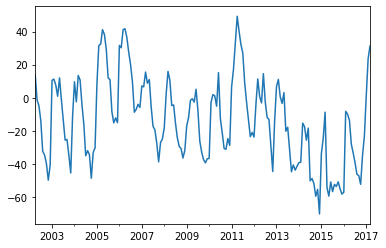

In [11]:
dfout.grace.dropna().plot()

In [12]:
# Write
dfout.to_csv("../data/grace.csv")